# Decision tree classifier: diabetes prediction

Absolutely minimal MVP (minimum viable product) solution.

## 1. Data acquisition

### 1.1. Load

In [23]:
import pandas as pd

# Load the data from the URL
data_df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")

In [24]:

print(data_df.head())

print("\nNull values in each column:")
print(data_df.isnull().sum())

print("\nData types and non-null counts:")
print(data_df.info())

print("\nBasic statistics:")
print(data_df.describe())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Null values in each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtyp

### 1.2. Train-test split

In [25]:
from sklearn.model_selection import train_test_split

# Separate features from labels
labels=data_df['Outcome']
features=data_df.drop('Outcome', axis=1)

training_features, testing_features, training_labels, testing_labels=train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=315
)

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features.columns.difference(categorical_cols)),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Apply transformations to training and testing features
training_features = preprocessor.fit_transform(training_features)
testing_features = preprocessor.transform(testing_features)


## 2. EDA

### 2.1. Features

In [27]:

def cross_val(model, features: pd.DataFrame, labels: pd.Series) -> list[float]:
    '''Reusable helper function to run cross-validation on a model. Takes model,
    Pandas data frame of features and Pandas data series of labels. Returns 
    list of cross-validation fold accuracy scores as percents.'''

    # Define the cross-validation strategy
    cross_validation=StratifiedKFold(n_splits=7, shuffle=True, random_state=315)

    # Run the cross-validation, collecting the scores
    scores=cross_val_score(
        model,
        features,
        labels,
        cv=cross_validation,
        n_jobs=-1,
        scoring='accuracy'
    )

    # Print mean and standard deviation of the scores
    print(f'Cross-validation accuracy: {(scores.mean() * 100):.2f} +/- {(scores.std() * 100):.2f}%')

    # Return the scores
    return scores

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import uniform, norm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier(random_state=315)

# Run the cross-validation
scores=cross_val(model, training_features, training_labels)

Cross-validation accuracy: 68.58 +/- 7.23%


All of the features are already numeric - we don't need to do anything for the model to run. Let's check the labels too.

### 2.2. Labels

In [29]:
training_labels.info()

<class 'pandas.core.series.Series'>
Index: 614 entries, 765 to 611
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
614 non-null    int64
dtypes: int64(1)
memory usage: 9.6 KB


### Missing Values

In [ ]:
import numpy as np

print("Missing values in each column:")
print(data_df.isnull().sum())

print("\nSummary statistics:")
print(data_df.describe())

zero_value_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for column in zero_value_columns:
    num_zero_values = (data_df[column] == 0).sum()
    print(f"Number of zero values in '{column}': {num_zero_values}")


Missing values in each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Summary statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000

In [31]:
data_df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
data_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
from sklearn.impute import SimpleImputer

columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

data_df[columns_to_impute] = data_df[columns_to_impute].replace(0, np.nan)

imputer = SimpleImputer(strategy='median')
data_df[columns_to_impute] = imputer.fit_transform(data_df[columns_to_impute])

print("Missing values after imputation:")
print(data_df.isnull().sum())


Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


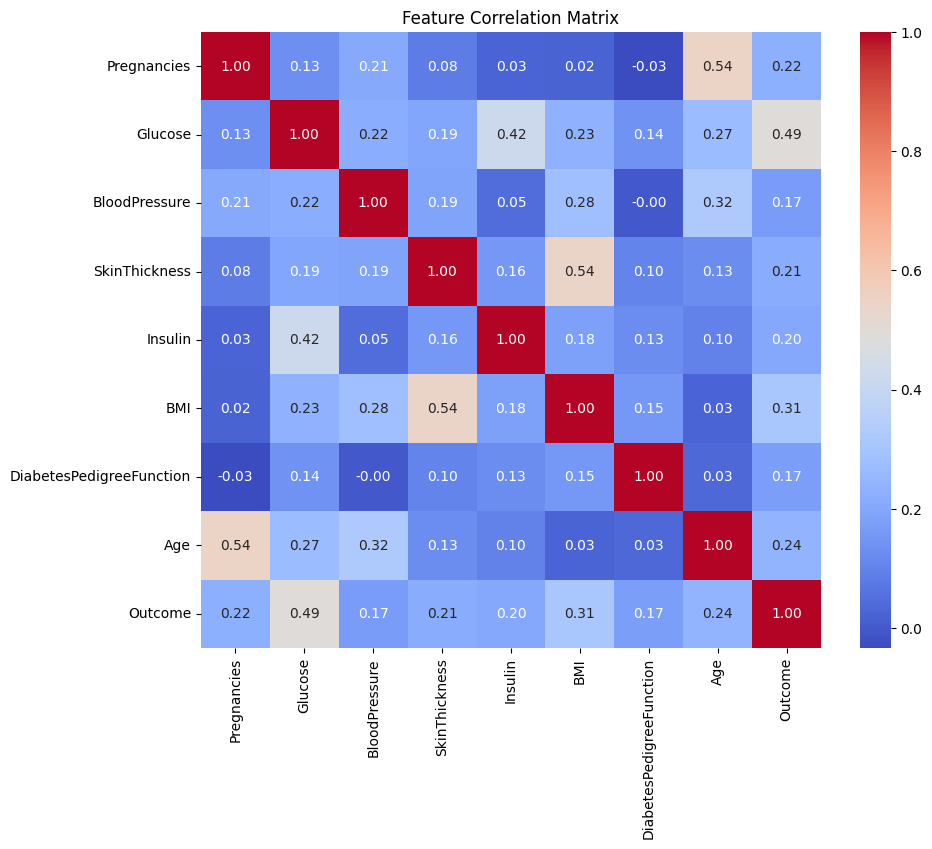

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = data_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier


model = DecisionTreeClassifier(random_state=315)

rfe_selector = RFE(estimator=model, n_features_to_select=5, step=1)
rfe_selector = rfe_selector.fit(training_features, training_labels)

selected_features = pd.DataFrame({
    "Feature": features.columns,
    "Selected": rfe_selector.support_,
    "Ranking": rfe_selector.ranking_
})
print(selected_features[selected_features["Selected"] == True])


                    Feature  Selected  Ranking
1                   Glucose      True        1
2             BloodPressure      True        1
5                       BMI      True        1
6  DiabetesPedigreeFunction      True        1
7                       Age      True        1


In [ ]:

model.fit(training_features, training_labels)
importances = model.feature_importances_

feature_importances = pd.DataFrame({"Feature": features.columns, "Importance": importances})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)
print(feature_importances)


                    Feature  Importance
1                   Glucose    0.306659
5                       BMI    0.169952
6  DiabetesPedigreeFunction    0.145262
7                       Age    0.105665
2             BloodPressure    0.088531
0               Pregnancies    0.068299
4                   Insulin    0.060484
3             SkinThickness    0.055148


In [ ]:
from sklearn.tree import DecisionTreeClassifier

model=DecisionTreeClassifier(random_state=315)
fit_result=model.fit(training_features, training_labels)


In [ ]:
import pandas as pd

print("Initial shape:", data_df.shape)

data_df_cleaned = data_df[(data_df['Glucose'] > 0) & 
                           (data_df['Insulin'] > 0) & 
                           (data_df['SkinThickness'] > 0) & 
                           (data_df['BloodPressure'] > 0)]


print("Cleaned shape:", data_df_cleaned.shape)


Initial shape: (768, 9)
Cleaned shape: (768, 9)


In [38]:
import pandas as pd

# Load your dataset
data_url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
data_df = pd.read_csv(data_url)

# Display the initial shape of the dataset
print("Initial shape:", data_df.shape)

# Remove rows where BloodPressure or Glucose is 0
data_df_cleaned = data_df[(data_df['BloodPressure'] > 0) & (data_df['Glucose'] > 0)]

# Display the shape after cleaning
print("Cleaned shape:", data_df_cleaned.shape)


Initial shape: (768, 9)
Cleaned shape: (728, 9)


In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Decision Tree model
model = DecisionTreeClassifier(random_state=315)

# Train the model on the training data
model.fit(training_features, training_labels)

# Predict on the test data
predictions = model.predict(testing_features)

# Evaluate model performance
accuracy = accuracy_score(testing_labels, predictions)
conf_matrix = confusion_matrix(testing_labels, predictions)
class_report = classification_report(testing_labels, predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy: 74.68%

Confusion Matrix:
[[82 17]
 [22 33]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        99
           1       0.66      0.60      0.63        55

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.74      0.75      0.74       154



## 4. Evaluation

In [40]:
from sklearn.metrics import accuracy_score

# Make predictions from test set features
predicted_labels=model.predict(testing_features)

# Score predictions from accuracy
percent_accuracy=accuracy_score(testing_labels, predicted_labels) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the test data')

Model is 74.7% accurate on the test data


Ok, done! Absolutely minimal decision tree classifier using ~10 statements. From here, there is **a lot** we can and should do to improve. But now we can do so incrementally, while maintaining a running state. We can also tell if anything we do 'works' in the performance sense by comparing to our baseline result of ~75% accuracy.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = DecisionTreeClassifier(random_state=315)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search.fit(training_features, training_labels)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


best_predictions = best_model.predict(testing_features)
best_accuracy = accuracy_score(testing_labels, best_predictions)

print(f"Best Hyperparameters: {best_params}")
print(f"Test Accuracy of Best Model: {best_accuracy * 100:.2f}%")


Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Test Accuracy of Best Model: 75.32%


In [ ]:

optimized_model = best_model  

cv_scores = cross_val(optimized_model, training_features, training_labels)

print(f"Cross-validation accuracy for the optimized model: {np.mean(cv_scores) * 100:.2f}% +/- {np.std(cv_scores) * 100:.2f}%")


Cross-validation accuracy: 75.09 +/- 4.94%
Cross-validation accuracy for the optimized model: 75.09% +/- 4.94%


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

final_predictions = best_model.predict(testing_features)

final_accuracy = accuracy_score(testing_labels, final_predictions)

conf_matrix = confusion_matrix(testing_labels, final_predictions)

class_report = classification_report(testing_labels, final_predictions)

print(f"Final Model Accuracy: {final_accuracy * 100:.2f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Final Model Accuracy: 75.32%

Confusion Matrix:
[[84 15]
 [23 32]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        99
           1       0.68      0.58      0.63        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154

